In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pyjet
import time
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

from matching import matching

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

# Comparing clustering times for no puppi and puppi
Orgin for eta = 10e10: https://root.cern.ch/doc/master/TVector3_8cxx_source.html#l00326

In [5]:
# event 24, jet 3 is problematic with puppi weights
min_idx = 0
max_idx = 4

pts = event_tree['PF_pt'].array(entry_start=min_idx, entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_start=min_idx, entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_start=min_idx, entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_start=min_idx, entry_stop=max_idx, library='np')
puppi_weights = event_tree['PF_puppiWeight'].array(entry_start=min_idx, entry_stop=max_idx, library='np')

In [3]:
def no_puppi_clustering(pts, etas, phis, masses, i):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and using puppi pileup mitigation.'''
    event_4vect = np.column_stack((pts, etas, phis, masses)).astype('float64')
    events = np.core.records.fromarrays(event_4vect.transpose(), names='pt, eta, phi, mass', formats = 'f8, f8, f8, f8')
    print("-------")
    t1 = time.time()
    sequence = pyjet.cluster(events, R=0.4, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=15)
    t2 = time.time()
    print("event: {}, time: {}".format(i,t2-t1))
    
    return my_jets


def puppi_clustering(pts, etas, phis, masses, puppi_weights, i):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and using puppi pileup mitigation.'''
    pts = pts*puppi_weights 
    event_4vect = np.column_stack((pts, etas, phis, masses)).astype('float64')
    events = np.core.records.fromarrays(event_4vect.transpose(), names='pt, eta, phi, mass', formats = 'f8, f8, f8, f8')
    print("-------")
    t1 = time.time()
    sequence = pyjet.cluster(events, R=0.4, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=15)
    t2 = time.time()
    print("event: {}, time: {}".format(i,t2-t1))
    
    return my_jets

In [6]:
print("No puppi:")
for i in range(max_idx-min_idx):
    no_puppi_clustering(pts[i], etas[i], phis[i], masses[i], i+min_idx)
    
    
print("\npuppi:")
for i in range(max_idx-min_idx):
    puppi_clustering(pts[i], etas[i], phis[i], masses[i], puppi_weights[i], i+min_idx)

No puppi:
-------
event: 0, time: 0.0010538101196289062
-------
event: 1, time: 0.0024280548095703125
-------
event: 2, time: 0.0012543201446533203
-------
event: 3, time: 0.0019860267639160156

puppi:
-------
event: 0, time: 0.01419210433959961
-------
event: 1, time: 0.34406566619873047
-------
event: 2, time: 0.017362594604492188
-------
event: 3, time: 0.12714028358459473


-------
event: 0, time: 0.0005729198455810547


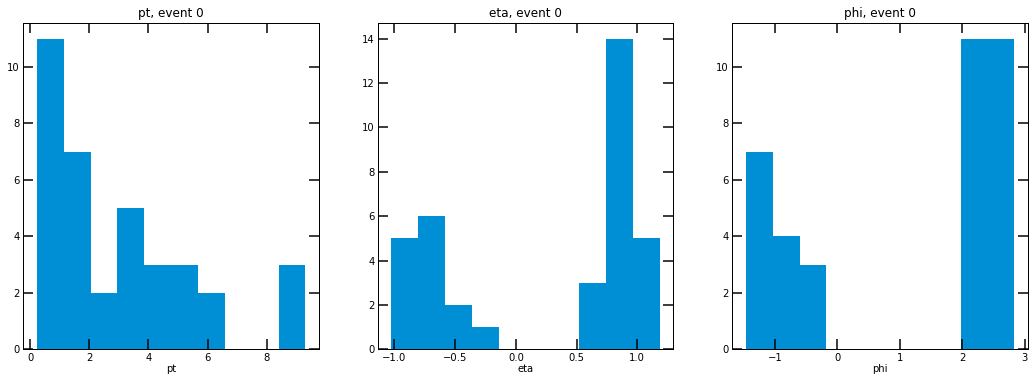

In [7]:
i = 0-min_idx
puppi_mask = np.where(puppi_weights[i]==0.0, False, True)
myjets_puppi = puppi_clustering(pts[i][puppi_mask], etas[i][puppi_mask], phis[i][puppi_mask], masses[i][puppi_mask], puppi_weights[i][puppi_mask], i+min_idx)

pt, eta, phi = [], [], []
for jet in myjets_puppi:
    pt.extend(jet.constituents_array()['pT'])
    eta.extend(jet.constituents_array()['eta'])
    phi.extend(jet.constituents_array()['phi'])
    
fig, ax = plt.subplots(1, 3, figsize=(18,6))

ax[0].hist(pt)
ax[0].set_title("pt, event {}".format(i))
ax[0].set_xlabel("pt")

ax[1].hist(eta)
ax[1].set_title("eta, event {}".format(i))
ax[1].set_xlabel("eta")

ax[2].hist(phi)
ax[2].set_title("phi, event {}".format(i))
ax[2].set_xlabel("phi")

plt.show()

# Number of PF with puppi weight = 0, as function of $\eta$

In [3]:
max_idx = 200

etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
puppi_weights = event_tree['PF_puppiWeight'].array(entry_stop=max_idx, library='np')

In [25]:
zero_weight_etas = []
etas_flat = []
for i in range(max_idx):
    zero_weight_mask = np.where(puppi_weights[i] == 0)[0]
    zero_weight_etas.extend(etas[i][zero_weight_mask])
    etas_flat.extend(etas[i])

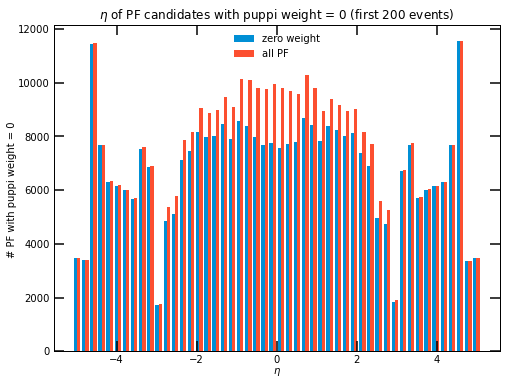

In [33]:
fig = plt.figure(figsize=(8,6)) 

plt.hist([zero_weight_etas, etas_flat], bins=50, label=['zero weight', 'all PF'])
plt.title(f"$\eta$ of PF candidates with puppi weight = 0 (first {max_idx} events)")
plt.xlabel("$\eta$")
plt.ylabel("# PF with puppi weight = 0 ")
plt.legend()
plt.show()

#fig.savefig("plots/eta_dist.pdf")

### Conclusion
Virtually all PF with $|\eta|>3$ have a zero weight.

# Comparing pt of reco and genjets

In [26]:
max_idx = 20000

reco_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
reco_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
reco_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')

gen_pts = event_tree['GenJet_pt'].array(entry_stop=max_idx, library='np')
gen_etas = event_tree['GenJet_eta'].array(entry_stop=max_idx, library='np')
gen_phis = event_tree['GenJet_phi'].array(entry_stop=max_idx, library='np')

In [27]:
norm_d_pt = []

for i in range(max_idx):
    matches = matching(reco_etas[i], reco_phis[i], gen_etas[i], gen_phis[i])
    for reco_idx, gen_idx in enumerate(matches):
        if gen_idx == -1:
            continue
        norm_d_pt.append((reco_pts[i][reco_idx] - gen_pts[i][gen_idx])/gen_pts[i][gen_idx])
        
norm_d_pt = np.array(norm_d_pt)

In [28]:
# get jets from testing
norm_d_pt = norm_d_pt[-14865:] 

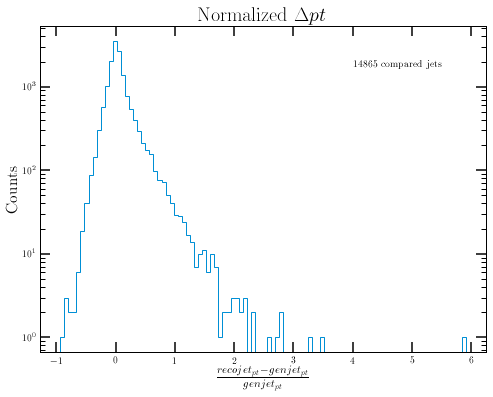

In [30]:
fig = plt.figure(figsize=(8,6))

plt.hist(norm_d_pt, bins=100, histtype='step')
text = "{} compared jets".format(len(norm_d_pt))
plt.yscale('log')
plt.title("Normalized $\Delta pt$")
plt.text(0.9, 0.9, text, ha='right', va='top', transform = plt.gca().transAxes)
plt.ylabel("Counts")
plt.xlabel("$\\frac{recojet_{pt} - genjet_{pt}}{genjet_{pt}}$")
plt.show()

fig.savefig("Delta_pt_reco_pt.pdf")

In [22]:
mask = np.where(abs(norm_d_pt)<1, True, False)

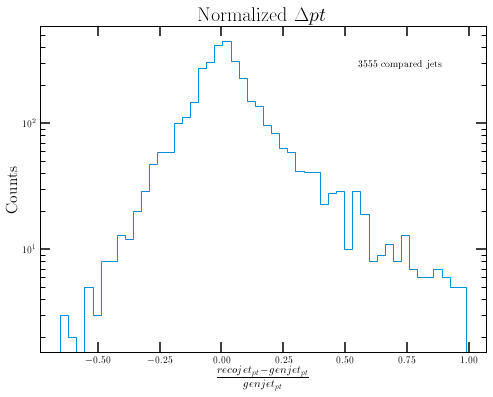

In [25]:
fig = plt.figure(figsize=(8,6))

plt.hist(norm_d_pt[mask], bins=50, histtype='step')
text = "{} compared jets".format(len(np.nonzero(mask)[0]))
plt.yscale('log')
plt.title("Normalized $\Delta pt$")
plt.text(0.9, 0.9, text, ha='right', va='top', transform = plt.gca().transAxes)
plt.ylabel("Counts")
plt.xlabel("$\\frac{recojet_{pt} - genjet_{pt}}{genjet_{pt}}$")
plt.show()

fig.savefig("Delta_pt_reco_pt_detail.pdf")